# Goal: investigate error rate impact and detector performance for rays that only partly affect a patch.

These results will be used to tune the detector sensitivity such that we can be
confident that we will always detect a ray that has negative effects. We will
then need to investigate the false positive rate of this detector.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import dill as pickle
import sinter
import qc_utils.stats

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [2]:
dx = 9
dz = 9
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True

mpmath.mp.dps = 50

In [3]:
baseline_result = sinter.collect(tasks=[patch.patch.get_sinter_task()], num_workers=6, decoders='pymatching', max_shots=10**7)[0]

In [4]:
sim = RayImpactSimulator(patch, spatial_window_size=2, only_full_windows=True)

In [5]:
spec = sim.generate_detector_spec(window_fpr=mpmath.mpf(1e-11), cycles_per_distillation=42, decay_nsteps=0)

In [6]:
distances = range(10)
signal_chances = np.zeros(len(distances), dtype=mpmath.mpf)
sinter_tasks = []
lers = np.zeros(len(distances))
for i,d in enumerate(distances):
    ray_coords = (len(patch.patch.device)//2, len(patch.patch.device[0]) + d)
    qubit_distances_from_center = np.linalg.norm(patch.patch.all_qubit_coords - np.array(ray_coords), axis=1)

    # see whether we detect a ray
    no_signal_chances = np.zeros(len(patch.patch.all_qubits), dtype=mpmath.mpf)
    for j,q in enumerate(patch.patch.all_qubits):
        no_signal_chances[j] = np.prod(1-np.array([mpmath.mpf(spec.detection_chance_function(qubit_distances_from_center[j], cycles_after_ray_impact=c)) for c in range(spec.detector_temporal_window_size)]))
    signal_chances[i] = 1-np.prod(no_signal_chances)

    # investigate logical error rate due to ray
    patch.reset()
    patch.force_cosmic_ray_by_coords(ray_coords)
    sinter_tasks.append(patch.patch.get_sinter_task({'json_metadata':{'distance':d}}))
    # ler, shots = patch.patch.count_logical_errors()
    # lers[i] = ler

In [7]:
sinter_results = sinter.collect(tasks=sinter_tasks, num_workers=6, decoders='pymatching', max_shots=10**7)

In [8]:
sorted_sinter_results = sorted(sinter_results, key=lambda x: x.json_metadata['distance'])

baseline_fit = sinter.fit_binomial(num_shots=baseline_result.shots, num_hits=baseline_result.errors, max_likelihood_factor=1000)
result_fits = [sinter.fit_binomial(num_shots=r.shots, num_hits=r.errors, max_likelihood_factor=1000) for r in sorted_sinter_results]

In [9]:
baseline_fit1 = qc_utils.stats.fit_binomial(num_shots=baseline_result.shots, num_hits=baseline_result.errors, max_likelihood_factor=1000)
result_fits1 = [qc_utils.stats.fit_binomial(num_shots=r.shots, num_hits=r.errors, max_likelihood_factor=1000) for r in sorted_sinter_results]

TypeError: 'int' object is not iterable

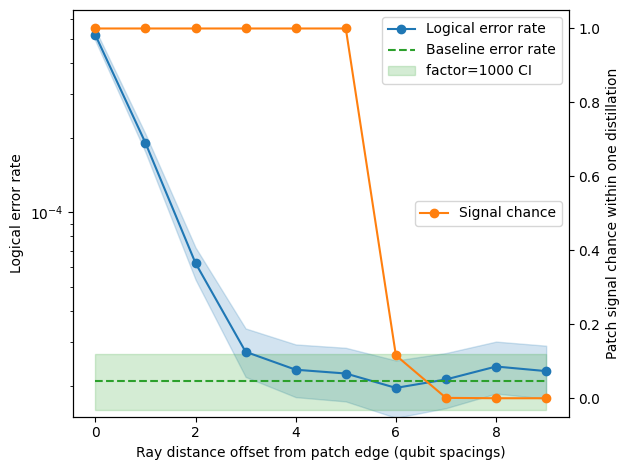

In [10]:
ax = plt.subplot(111)
ax1 = ax.twinx()
ax.plot(distances, [f.best for f in result_fits], 'o-', color='C0', label='Logical error rate')
ax.fill_between(distances, [f.low for f in result_fits], [f.high for f in result_fits], color='C0', alpha = 0.2)

ax.plot(distances, baseline_fit.best*np.ones(len(distances)), '--', color='C2', label='Baseline error rate')
ax.fill_between(distances, baseline_fit.low, baseline_fit.high, color='C2', alpha = 0.2, label='factor=1000 CI')
ax.set_ylabel('Logical error rate')
ax.set_yscale('log')
ax.set_ylim(1.5e-5)
ax.set_xlabel('Ray distance offset from patch edge (qubit spacings)')

# TODO: not showing up in legend
ax1.plot(distances, signal_chances, 'o-', color='C1', label='Signal chance')
ax1.set_ylabel('Patch signal chance within one distillation')

ax.legend()
ax1.legend(loc='center right')

plt.tight_layout()
plt.savefig('exterior_detection.png', dpi=300)
plt.show()

In [ ]:
patch_fpr_per_cycle = 1-(1-spec.baseline_signal_rate)**len(sim._windows)
patch_fpr_per_cycle

2.2521984277545926e-10

In [ ]:
patch_fpr_per_second = patch_fpr_per_cycle/patch.patch.cycle_time()
patch_fpr_per_second

0.00024061949014472144